In [1]:
#import libraries
import numpy as np
import pandas as pd

In [2]:
#reading train_csv file
train_set = pd.read_csv('../input/hackerearth-deep-learning-challenge-holidayseason/dataset/train.csv')

In [3]:
train_set.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [4]:
# we have 2 columns given image and it's repective class
train_set.columns

Index(['Image', 'Class'], dtype='object')

In [5]:
#get some intution about classes of image
import matplotlib.pyplot as plt
import seaborn as sns

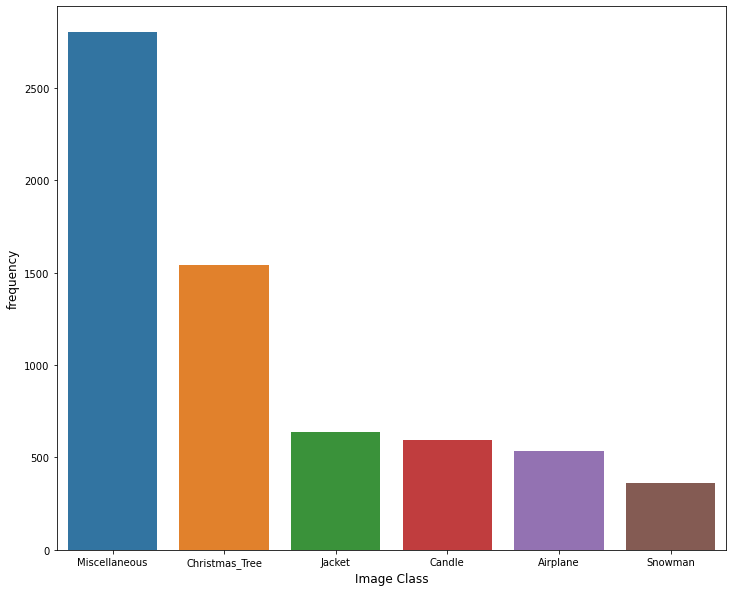

In [6]:
#store frequency of image in given class
label_counts = train_set['Class'].value_counts()

#initalize plot figure of given size
plt.figure(figsize=(12,10))

#draw image of label_counts using seaborn barplot
sns.barplot(label_counts.index,label_counts.values)

#lable x-axis
plt.xlabel('Image Class', fontsize =12)

#lable y-axis
plt.ylabel('frequency', fontsize = 12)
plt.show()

In [7]:
#to read images
import cv2

#use to show progress bar
from tqdm import tqdm

In [8]:
# In this dataset we have different shape of image, we fix to 64*64
img_size = 64

def read_img(img_path):
    # cv2.IMREAD_COLOR to store image in color form(length*width*numberofchannels)
    img = cv2.imread(img_path,cv2.IMREAD_COLOR)
    #resize image
    img = cv2.resize(img, (img_size, img_size))
    return img

In [9]:
#store image in form of list of matrices
train_img = []

# store path of training image folder
train_img_path = '../input/hackerearth-deep-learning-challenge-holidayseason/dataset/train/'

for img_name in tqdm(train_set['Image'].values):
    train_img.append(read_img(train_img_path + img_name))

100%|██████████| 6469/6469 [00:38<00:00, 168.05it/s]


In [10]:
# as pixel values is in between 0-255 so we divide by 255 so that range is in between 0-1
# as it easier for your cost function to find a local or global minimum and cnn train more efficiently

x_train = np.array(train_img,np.float32)/255

In [11]:
x_train.shape

(6469, 64, 64, 3)

In [12]:
# store classes in form of index
label_list = train_set['Class'].tolist()
label_numeric = {k: v+1 for v, k in enumerate(set(label_list))}
print(label_numeric)

print(label_list[0])

#store it in form of numpy array
y_train = [label_numeric[k] for k in label_list]
y_train = np.array(y_train)

{'Jacket': 1, 'Snowman': 2, 'Christmas_Tree': 3, 'Candle': 4, 'Airplane': 5, 'Miscellaneous': 6}
Miscellaneous


In [13]:
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import tensorflow as tf

In [14]:
# convert all classes of data in form of category in binary form 
y_train = to_categorical(y_train)

In [15]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

Load Resnet model

In [16]:
base_model = applications.ResNet50(weights='imagenet',
                                   include_top=False,
                                   input_shape=(img_size,img_size, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
# base_model.trainable = True
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
# layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [18]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.3))
add_model.add(Dense(128, activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [19]:
batch_size = 32      
epochs = 200                

# data augmentation
train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode="nearest")

train_datagen.fit(x_train)

In [20]:

# chk_path = 'holiday.h5'
# log_dir = 'checkpoint/logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# checkpoint = ModelCheckpoint(filepath=chk_path,
#                              save_best_only=True,
#                              verbose=1,
#                              mode='min',
#                              moniter='val_loss')

# earlystop = EarlyStopping(monitor='val_loss', 
#                           min_delta=0, 
#                           patience=3, 
#                           verbose=1, 
#                           restore_best_weights=True)
                        
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.2, 
#                               patience=6, 
#                               verbose=1, 
#                               min_delta=0.0001)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
# csv_logger = CSVLogger('training_log')

# callbacks = [checkpoint,reduce_lr,csv_logger]

In [21]:
# train model
history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs)

Epoch 1/200
202/202 [==============================] - 12s 59ms/step - loss: 2.2389 - accuracy: 0.3901
Epoch 2/200
202/202 [==============================] - 11s 57ms/step - loss: 1.3736 - accuracy: 0.5447
Epoch 3/200
202/202 [==============================] - 12s 59ms/step - loss: 1.1558 - accuracy: 0.6079
Epoch 4/200
202/202 [==============================] - 12s 61ms/step - loss: 1.0322 - accuracy: 0.6355
Epoch 5/200
202/202 [==============================] - 12s 57ms/step - loss: 0.9771 - accuracy: 0.6598
Epoch 6/200
202/202 [==============================] - 12s 60ms/step - loss: 0.9188 - accuracy: 0.6773
Epoch 7/200
202/202 [==============================] - 11s 56ms/step - loss: 0.8518 - accuracy: 0.7027
Epoch 8/200
202/202 [==============================] - 12s 57ms/step - loss: 0.8384 - accuracy: 0.7070
Epoch 9/200
202/202 [==============================] - 13s 63ms/step - loss: 0.7838 - accuracy: 0.7218
Epoch 10/200
202/202 [==============================] - 12s 61ms/step - l

In [22]:
import os.path

test_images = os.listdir('../input/hackerearth-deep-learning-challenge-holidayseason/dataset/test/')
test_img = []
for image in test_images:
    test_img.append(read_img('../input/hackerearth-deep-learning-challenge-holidayseason/dataset/test/' + image))
    


In [23]:
# store image in form of matrices and predict the test_img
x_test = np.array(test_img, np.float32) / 255
predictions = model.predict(x_test)

In [24]:
predictions = np.argmax(predictions, axis=1)
rev_y = {v:k for k,v in label_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

In [25]:
# store the prediction
sub = pd.DataFrame({'Image': test_images, 'Class': pred_labels})
sub.to_csv('submission.csv', index = False)
sub.head()

,Image,Class
0,image7761.jpg,Miscellaneous
1,image3202.jpg,Miscellaneous
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree
